<a href="https://colab.research.google.com/github/motykatomasz/DeepImagePrior/blob/master/DeepImagePrior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reproducing Deep Image Prior paper
=====================

In this notebook we reproduce Table 1 in Deep Image Prior paper. Although the authors of the paper made the code available online, this is out approach to independently reproduce thair results. 
We developed the code in Jupyter notebook and it is compatible with Google Colab platform to be used with GPU.


## What is Deep Image Prior

In the paper, the authors argue that a great
deal of image statistics are captured by the structure of
a convolutional image generator independent of learning.
What it means is that we can train the generator netowrk on a single degraded image, instead of large dataset of example images,
to reconstruct the image. In this scheme, the network weights serve
as a parametrization of the restored image.


## How does it work?

Lets assume that our image x is under following process:

$ x \Rightarrow Degradation \Rightarrow  \hat{x} \Rightarrow  Restoration \Rightarrow x^{*} $

Our goal is to find $ x^{*}$.
We can do that by finding the MAP estimate of our posterior distribution of clean images:

\begin{equation}
MAP: x^{*} = argmax_{x} p(x|\hat{x})
\end{equation}

As it is usually the case, obtaining posterior distribution $p(x|\hat{x})$ is intractable. We can rewrite the equation using Bayes theorem:

\begin{equation}
p(x|\hat{x}) = \frac{p(\hat{x}|x)p(x)}{p(\hat{x})} \sim p(\hat{x}|x)p(x)
\end{equation}


to be continued...


In [1]:
!pip install torch torchvision Pillow
!apt-get update
!apt-get install subversion
!svn checkout https://github.com/DmitryUlyanov/deep-image-prior/trunk/data

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,784 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [

In [1]:
try:
    import models
except ImportError:
    from getpass import getpass
    branch = input('branch (master): ')
    branch = 'master' if branch == '' else branch
    !pip install --ignore-installed git+https://{input('git user: ')}:{getpass('git password: ')}@github.com/motykatomasz/DeepImagePrior@{branch}

In [1]:
import torch
from PIL import Image
from numpy import asarray
from models.unet import UNet
import torch.optim as optim
from models.utils import z, imshow, image_to_tensor, tensor_to_image
from models.configs import textInpaintingSettings

In [2]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs')

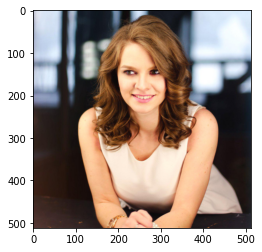

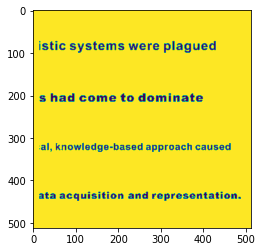

4
a torch.Size([1, 128, 16, 16])
b torch.Size([1, 4, 16, 16])
3
a torch.Size([1, 128, 32, 32])
b torch.Size([1, 4, 32, 32])
2
a torch.Size([1, 128, 64, 64])
b torch.Size([1, 4, 64, 64])
1
a torch.Size([1, 128, 128, 128])
b torch.Size([1, 4, 128, 128])
0
a torch.Size([1, 128, 256, 256])
b torch.Size([1, 4, 256, 256])
torch.Size([1, 3, 512, 512])
Step :0, Loss: 113596.71875


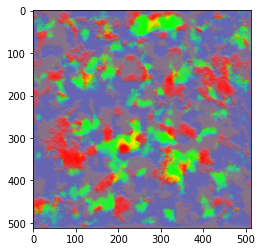

OUTPUT IMAGE
4
a torch.Size([1, 128, 16, 16])
b torch.Size([1, 4, 16, 16])
3
a torch.Size([1, 128, 32, 32])
b torch.Size([1, 4, 32, 32])
2
a torch.Size([1, 128, 64, 64])
b torch.Size([1, 4, 64, 64])
1
a torch.Size([1, 128, 128, 128])
b torch.Size([1, 4, 128, 128])
0
a torch.Size([1, 128, 256, 256])
b torch.Size([1, 4, 256, 256])
torch.Size([1, 3, 512, 512])
Step :1, Loss: 106617.703125
4
a torch.Size([1, 128, 16, 16])
b torch.Size([1, 4, 16, 16])
3
a torch.Size([1, 128, 32, 32])
b torch.Size([1, 4, 32, 32])
2
a torch.Size([1, 128, 64, 64])
b torch.Size([1, 4, 64, 64])
1
a torch.Size([1, 128, 128, 128])
b torch.Size([1, 4, 128, 128])
0
a torch.Size([1, 128, 256, 256])
b torch.Size([1, 4, 256, 256])
torch.Size([1, 3, 512, 512])


KeyboardInterrupt: 

In [3]:
img_path = "data/inpainting/kate.png"
img = Image.open(img_path)
imshow(asarray(img))

mask_path = "data/inpainting/kate_mask.png"
mask = Image.open(mask_path)
imshow(asarray(mask))

x = image_to_tensor(img)
mask = image_to_tensor(mask)

net = UNet(32, textInpaintingSettings)

if torch.cuda.is_available():
    net = net.cuda()

mse = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Num of iters for training
num_iters = 5000

# Num of iters when to save image
save_frequency = 250

#Since we only have 1 image to train on, we set zero_gradienet once at the beginning
optimizer.zero_grad()

z0 = z(shape=(img.height, img.width), channels=32)

for i in range(num_iters):
    output = net(z0)

    # Optimizer
    loss = torch.sum(torch.mul((output - x), mask)**2)
    # loss = mse(output * mask, x * mask)
    loss.backward()
    optimizer.step()

    writer.add_scalar('Train/loss',loss.item(),i)
    print('Step :{}, Loss: {}'.format(i, loss.data.cpu()))
    if i % save_frequency == 0:
        out_img = tensor_to_image(output)
        imshow(asarray(out_img))
        print('OUTPUT IMAGE')
    
    writer.close()
        
%tensorboard --logdir=runs